# <div style="text-align: center"><font color='gray' textalign='center'>Lab 3: Classification</font></div>

In [1]:
import pandas as pd
import ds_functions as ds
import matplotlib.pyplot as plt

data = pd.read_csv('heart_failure_clinical_records_dataset.csv', sep = ',')

data["sex"] = data["sex"].astype("bool")
data["anaemia"] = data["anaemia"].astype("bool")
data["diabetes"] = data["diabetes"].astype("bool")
data["high_blood_pressure"] = data["high_blood_pressure"].astype("bool")
data["smoking"] = data["smoking"].astype("bool")
data["DEATH_EVENT"] = data["DEATH_EVENT"].astype("bool")

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 3 * IQR)) |(data > (Q3 + 3 * IQR))).any(axis=1)]
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,False,582,False,20,True,265000.0,1.9,130,True,False,4,True
2,65.0,False,146,False,20,False,162000.0,1.3,129,True,True,7,True
3,50.0,True,111,False,20,False,210000.0,1.9,137,True,False,7,True
4,65.0,True,160,True,20,False,327000.0,2.7,116,False,False,8,True
5,90.0,True,47,False,40,True,204000.0,2.1,132,True,True,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,52.0,False,190,True,38,False,382000.0,1.0,140,True,True,258,False
293,63.0,True,103,True,35,False,179000.0,0.9,136,True,True,270,False
294,62.0,False,61,True,38,True,155000.0,1.1,143,True,True,270,False
295,55.0,False,1820,False,38,False,270000.0,1.2,139,False,False,271,False


# <font color='gray'> Scaling </font>

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_nr = data.select_dtypes(include='number')
df_sb = data.select_dtypes(include=['category', 'bool'])

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr.join(df_sb, how='right')

In [3]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr.join(df_sb, how='right')

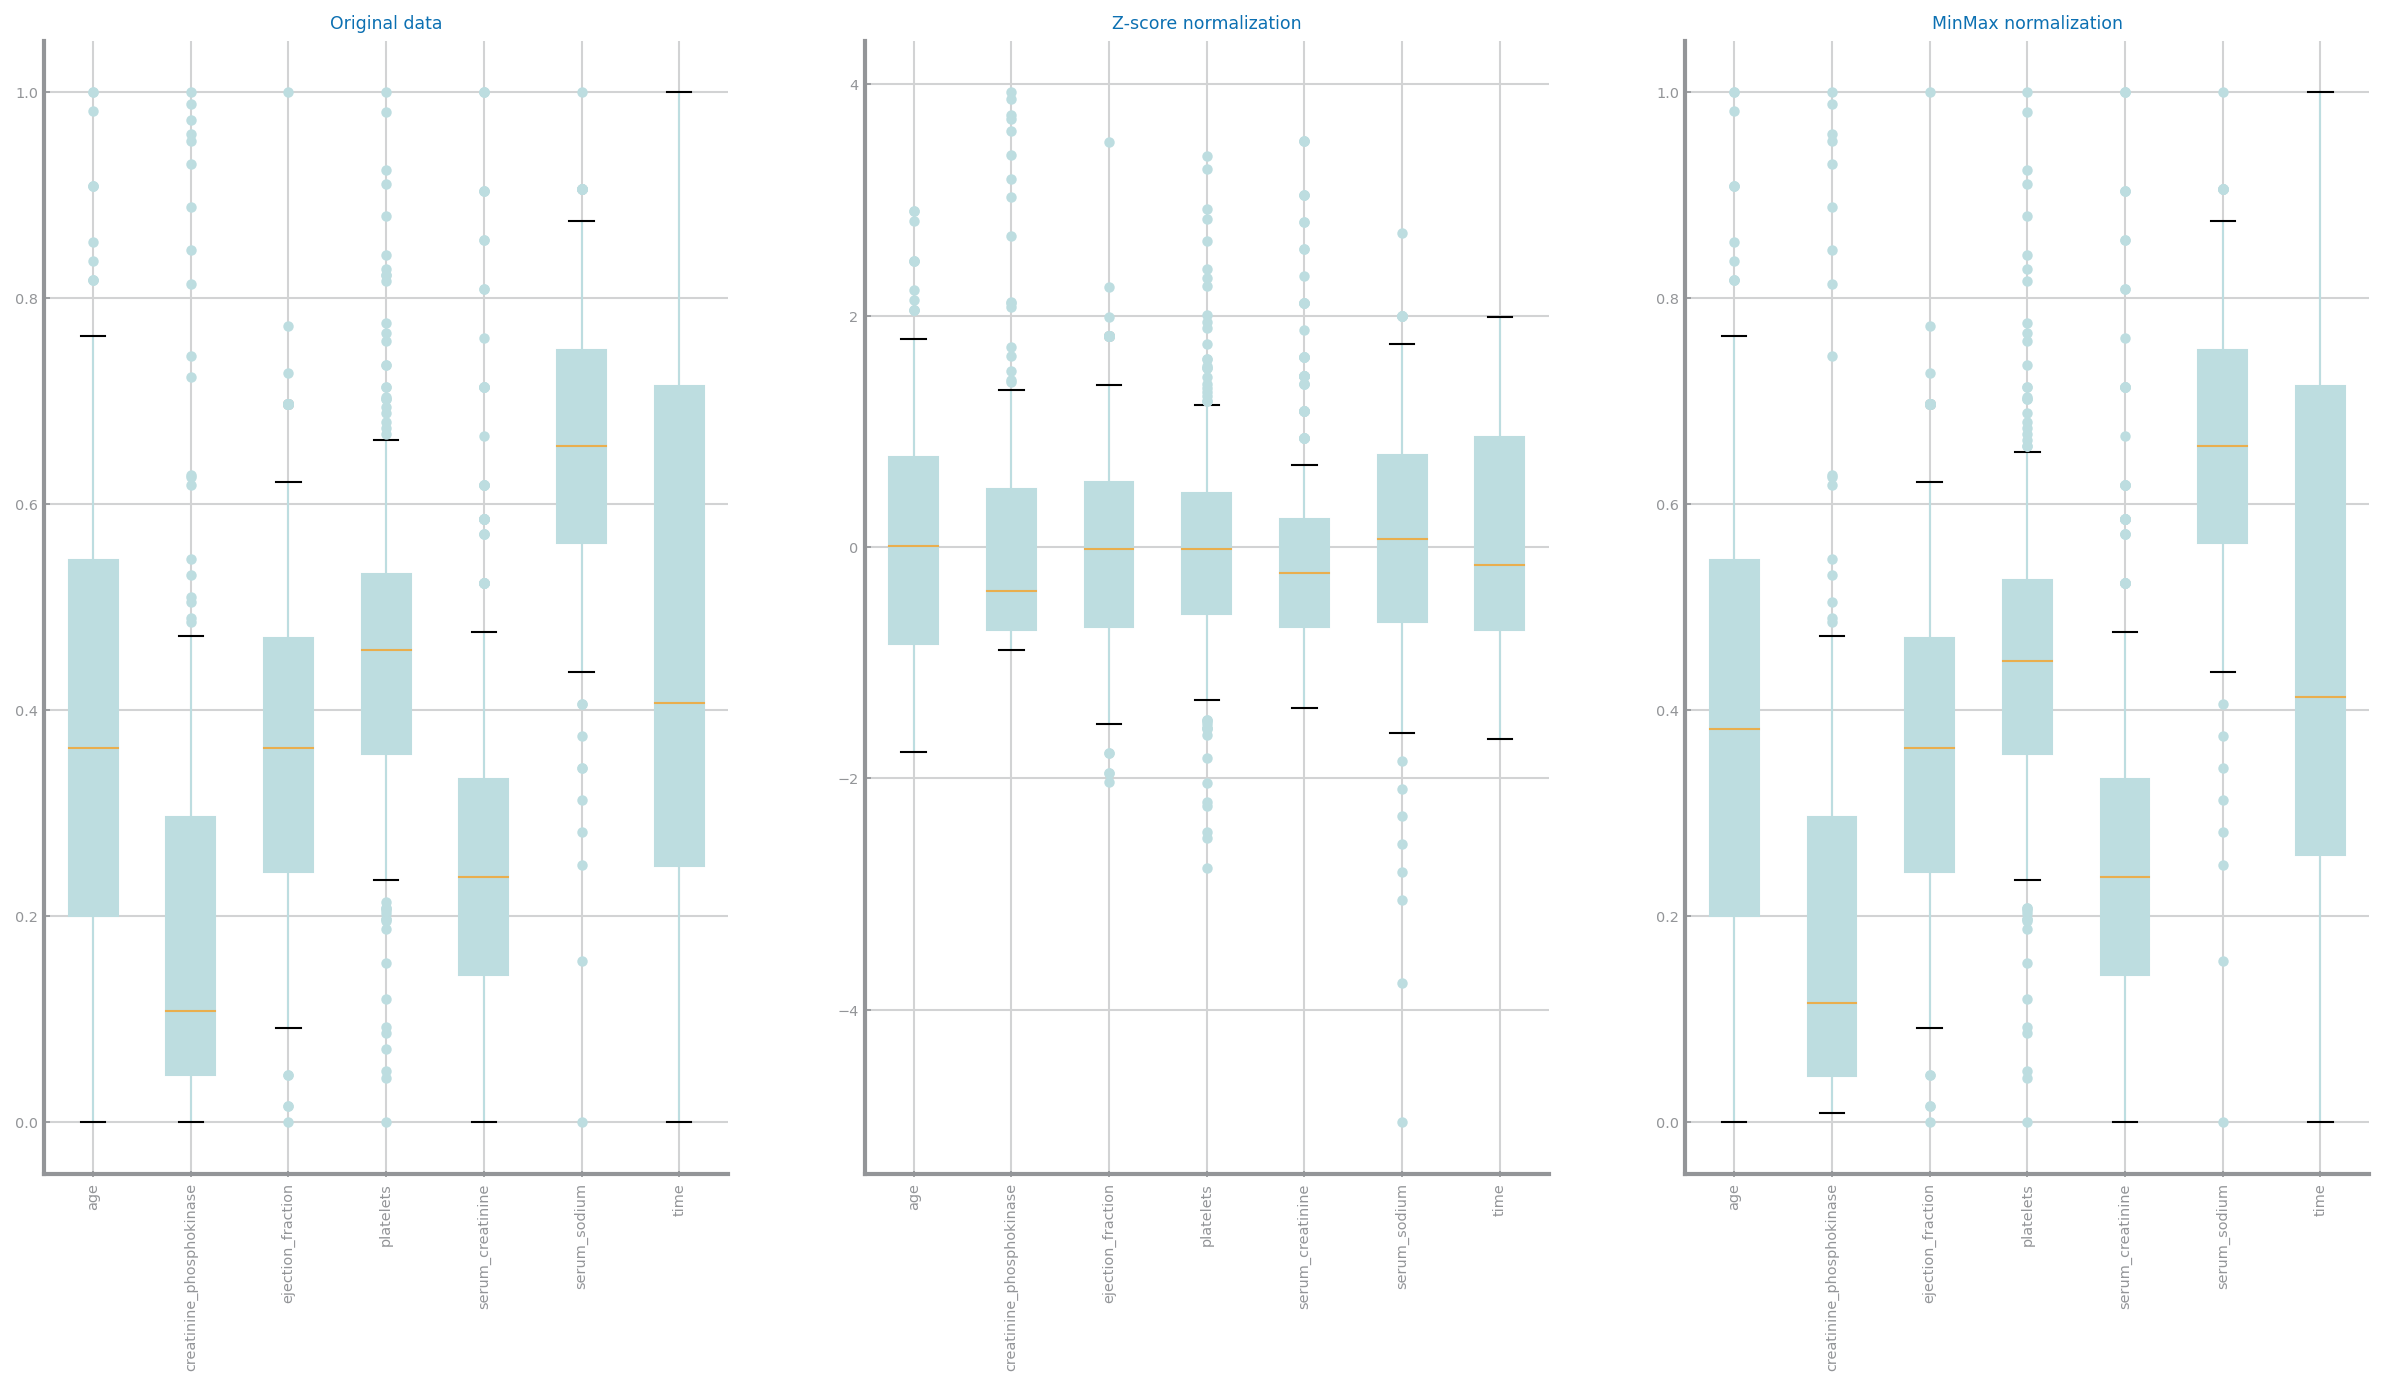

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
df_nr.select_dtypes(exclude=['category', 'bool']).boxplot(ax=axs[0, 0], rot = 90)
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.select_dtypes(exclude=['category', 'bool']).boxplot(ax=axs[0, 1], rot = 90)
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.select_dtypes(exclude=['category', 'bool']).boxplot(ax=axs[0, 2], rot = 90)
#fig.tight_layout()

# <font color='gray'> Training Models </font>

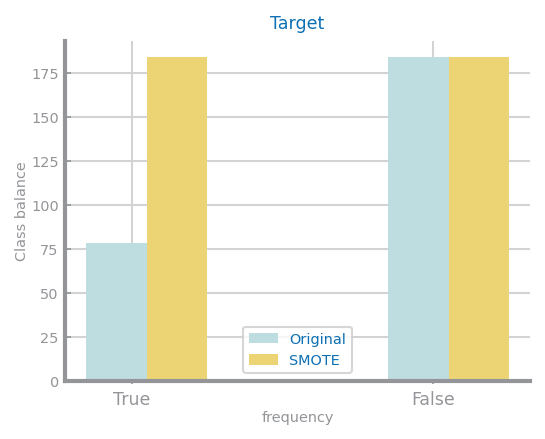

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

target_count = data['DEATH_EVENT'].value_counts()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

df_class_min = data[data['DEATH_EVENT'] == min_class]
df_class_max = data[data['DEATH_EVENT'] != min_class]

values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = data.pop('DEATH_EVENT').values
X = data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

X = smote_X
y = smote_y
target = 'DEATH_EVENT'
positive = True
negative = False

labels: np.ndarray = pd.unique(y)
labels.sort()

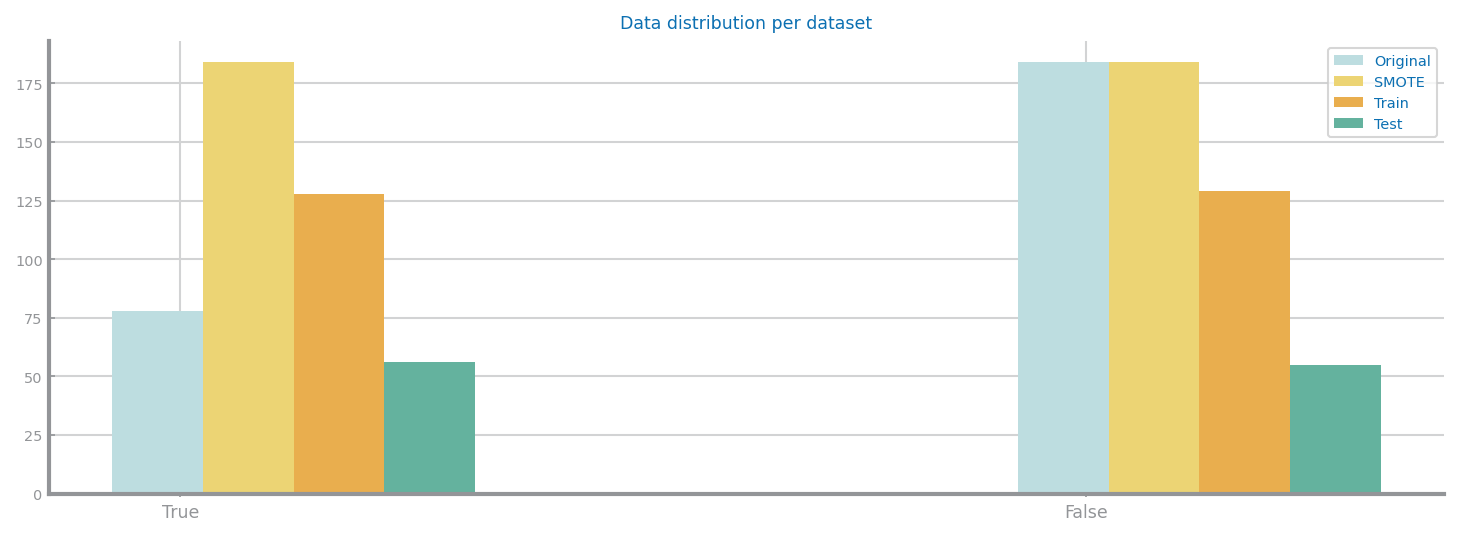

In [6]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

# <font color='gray'> Naive Bayes - MinMax</font>

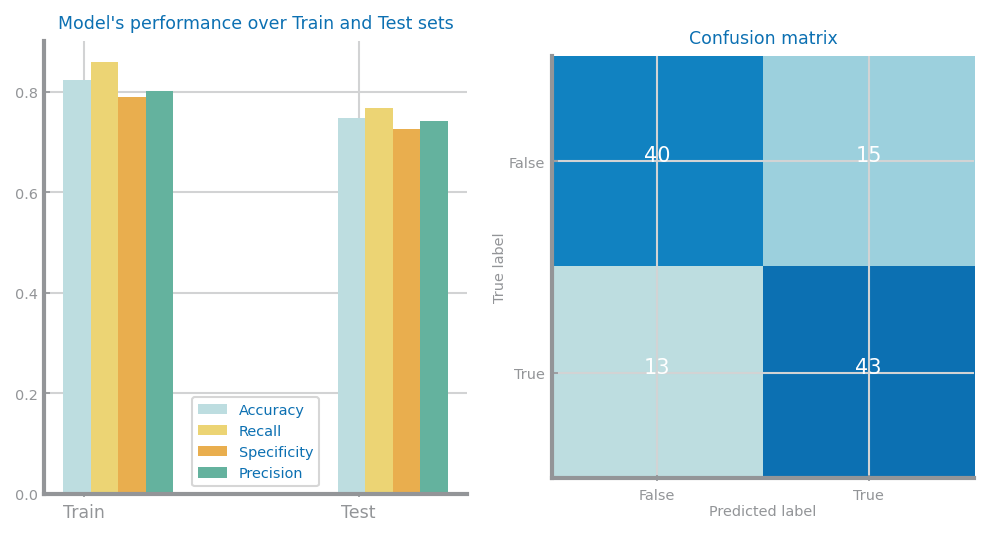

In [7]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

data = norm_data_minmax

y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

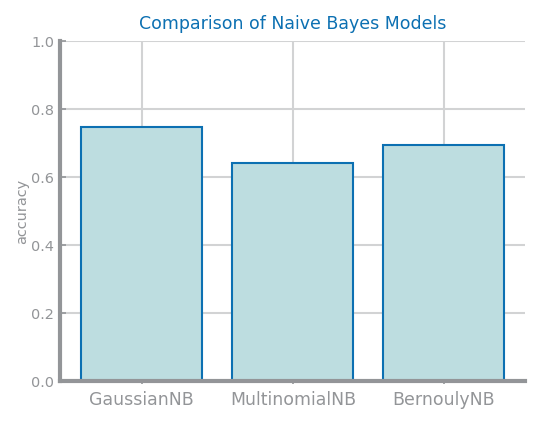

In [8]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'> KNN - MinMax</font>

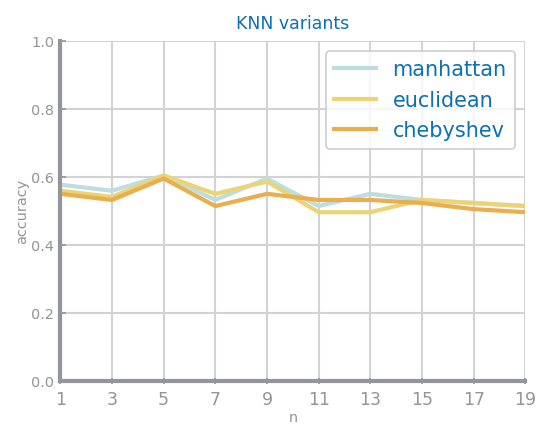

Best results with 5 neighbors and manhattan


In [9]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
train_values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    y_trn_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        prd_trn_Y = knn.predict(trnX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues
    train_values[d] = y_trn_values

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

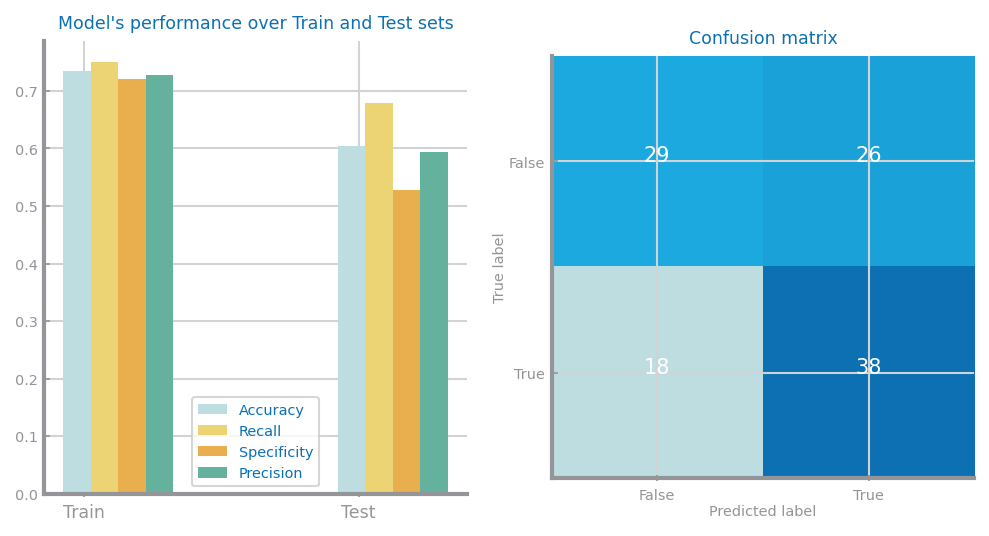

In [10]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

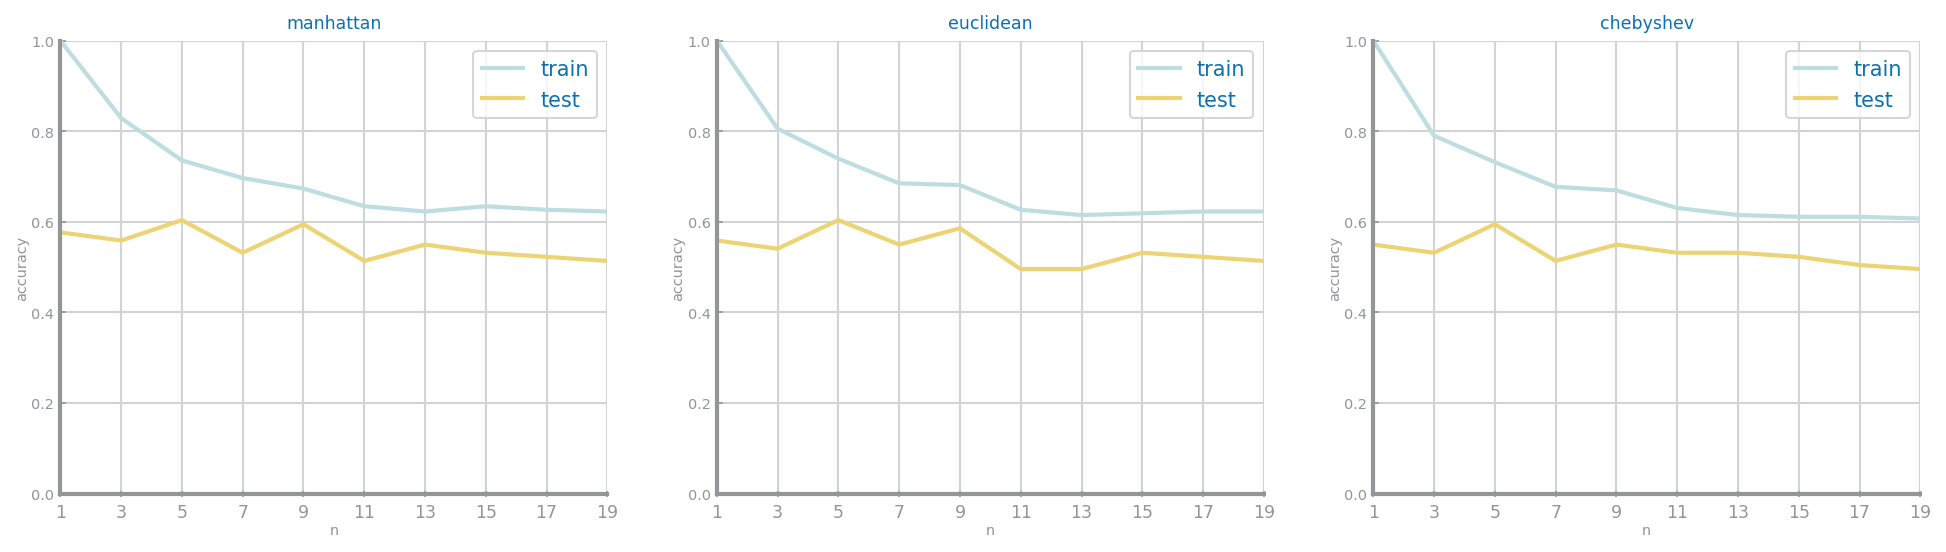

In [11]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
for i in range(len(dist)):
    ds.multiple_line_chart(nvalues, {'train': train_values[dist[i]], 'test': values[dist[i]]}, ax=axs[0, i], title=dist[i], xlabel='n', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'>Decision Trees - MinMax</font>

<Figure size 600x450 with 0 Axes>

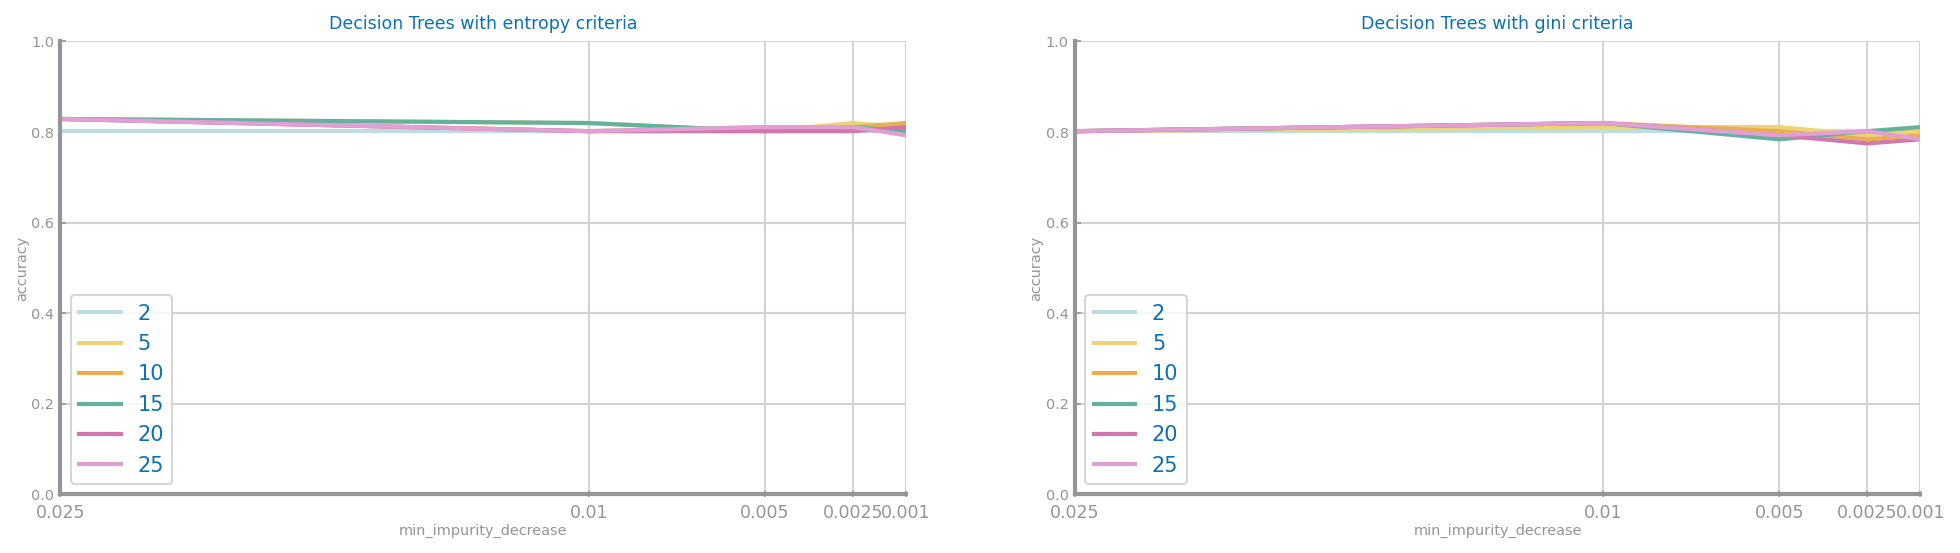

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.83


In [12]:
from sklearn.tree import DecisionTreeClassifier

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

criteria_test_values = {}
criteria_train_values = {}

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    train_values = {}
    for d in max_depths:
        yvalues = []
        y_trn_values = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            prd_trn_Y = tree.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
        train_values[d] = y_trn_values
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
    
    criteria_test_values[f] = values
    criteria_train_values[f] = train_values
    

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

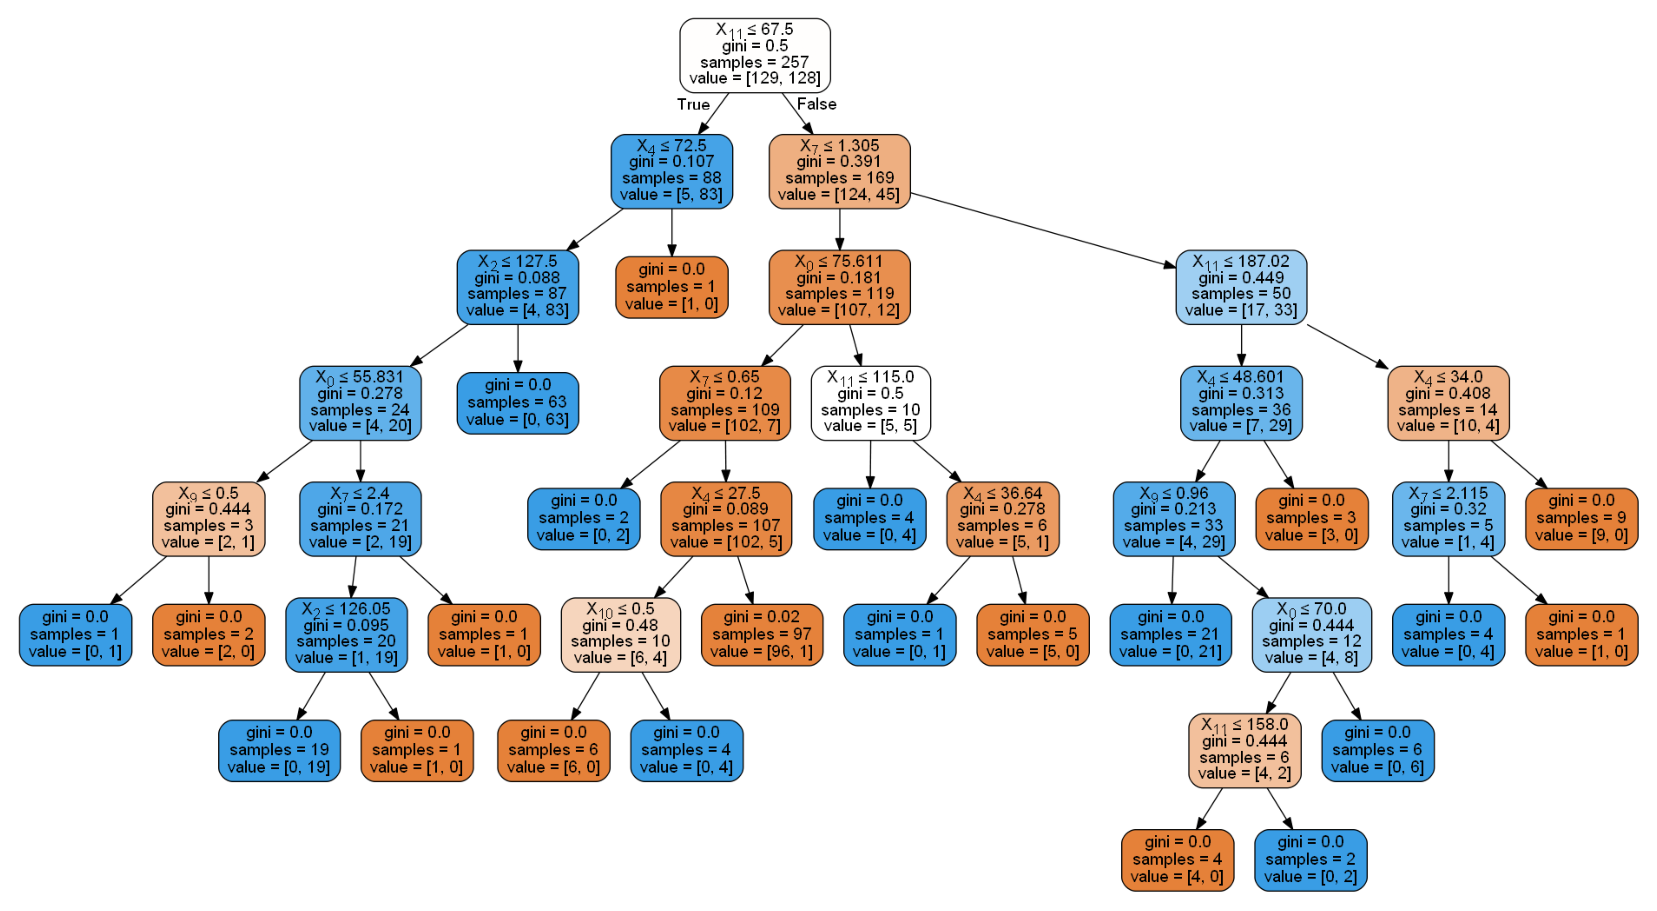

In [13]:
from sklearn.tree import export_graphviz
import pydot

dot_data = export_graphviz(tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
(graph,) = pydot.graph_from_dot_file('dtree.dot')
graph.write_png('dtree.png')

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

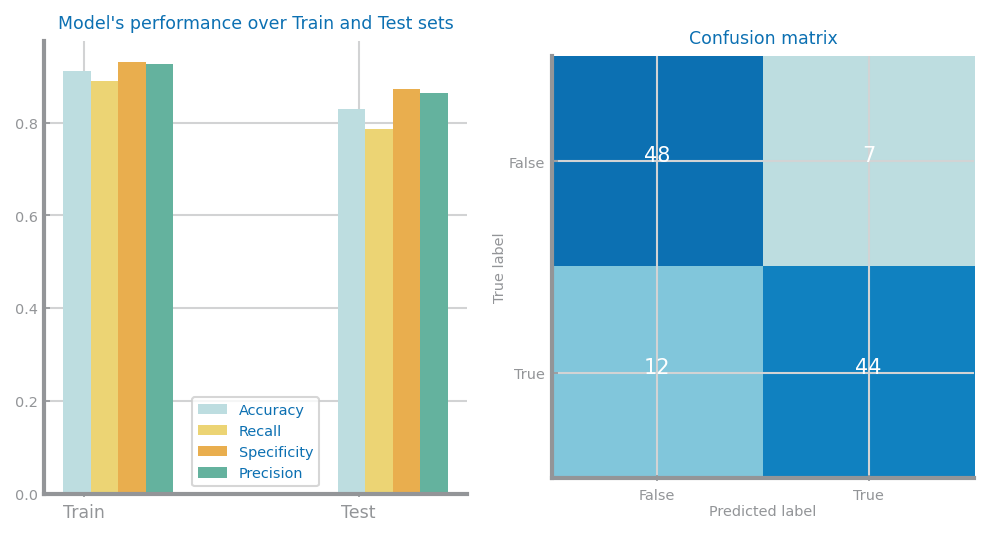

In [14]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

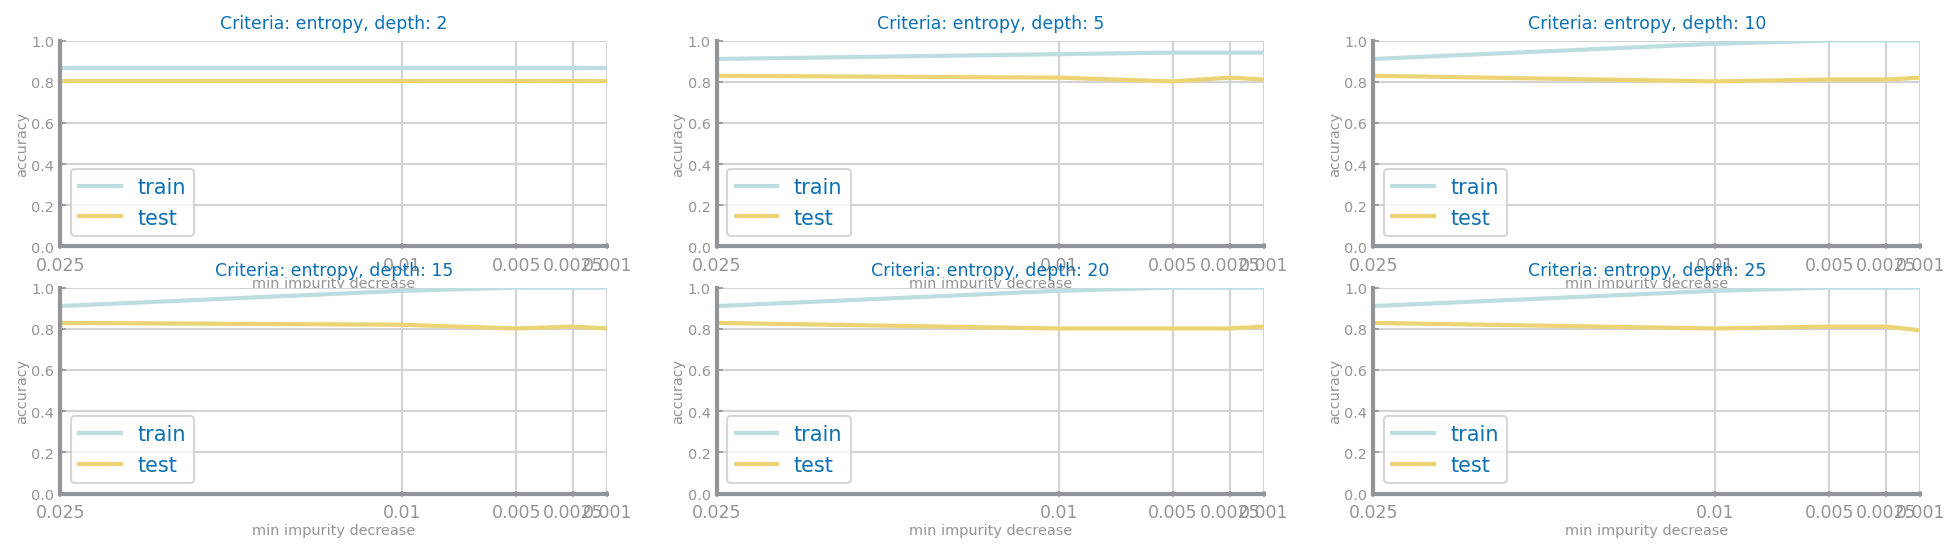

<Figure size 600x450 with 0 Axes>

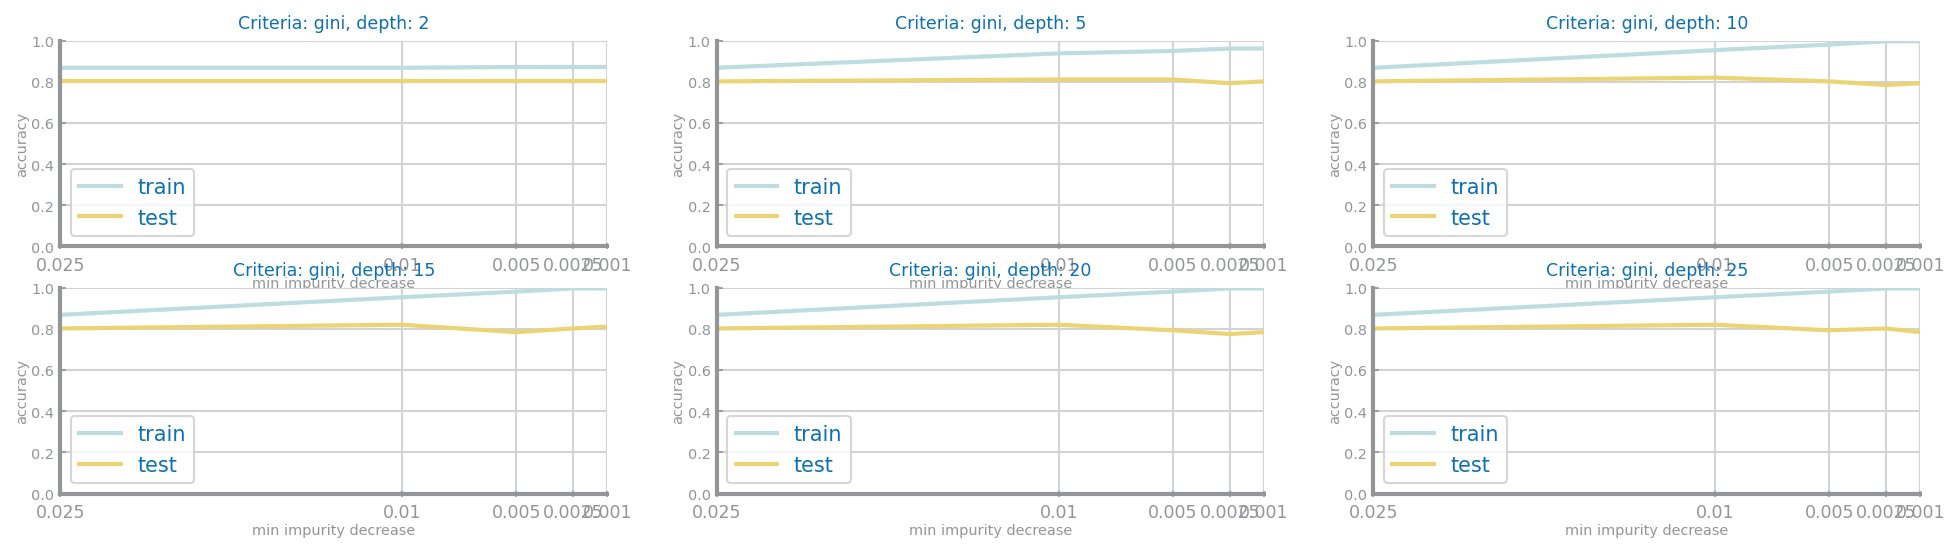

In [15]:
for j in range(len(criteria)):
    train_values = criteria_train_values[criteria[j]]
    test_values = criteria_test_values[criteria[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_depths)):
        ds.multiple_line_chart(min_impurity_decrease, {'train': train_values[max_depths[i]], 'test': test_values[max_depths[i]]}, ax=axs[int(i/3), i%3], title='Criteria: ' + criteria[j]+ ', depth: ' + str(max_depths[i]), xlabel='min impurity decrease', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Random Forests - MinMax Data</font>

<Figure size 600x450 with 0 Axes>

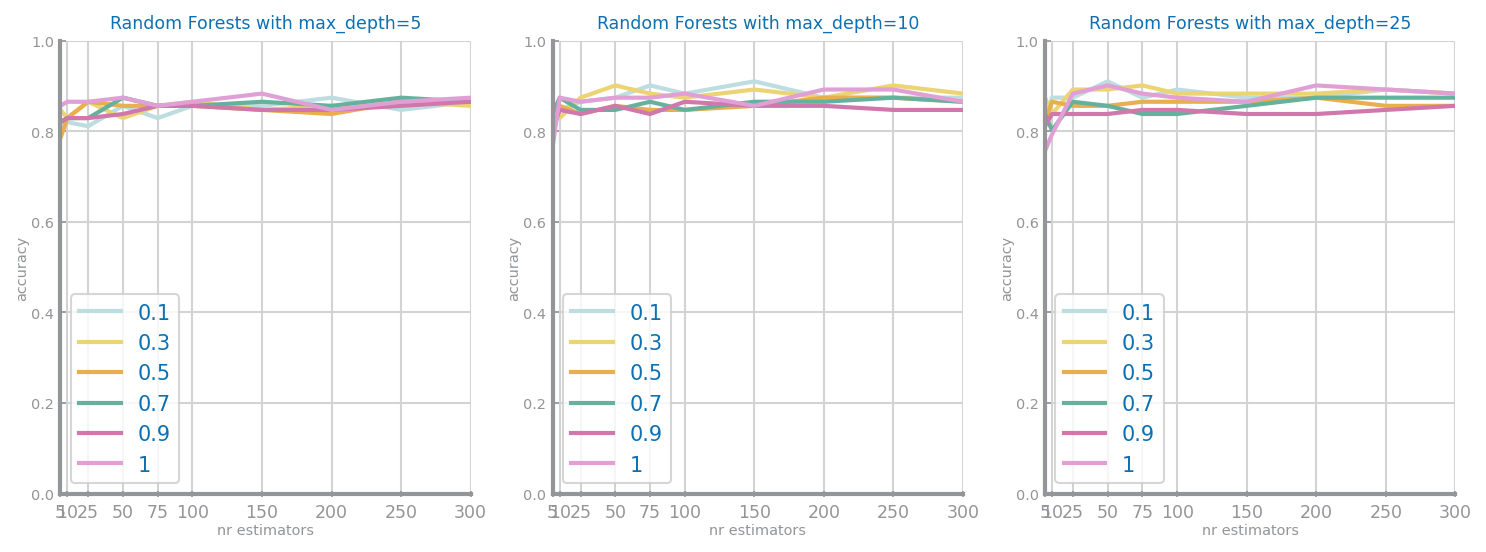

Best results with depth=10, 0.10 features and 150 estimators, with accuracy=0.91


In [16]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None


max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for f in max_features:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            prd_trn_y = rf.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        train_values[f] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values
    
    
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

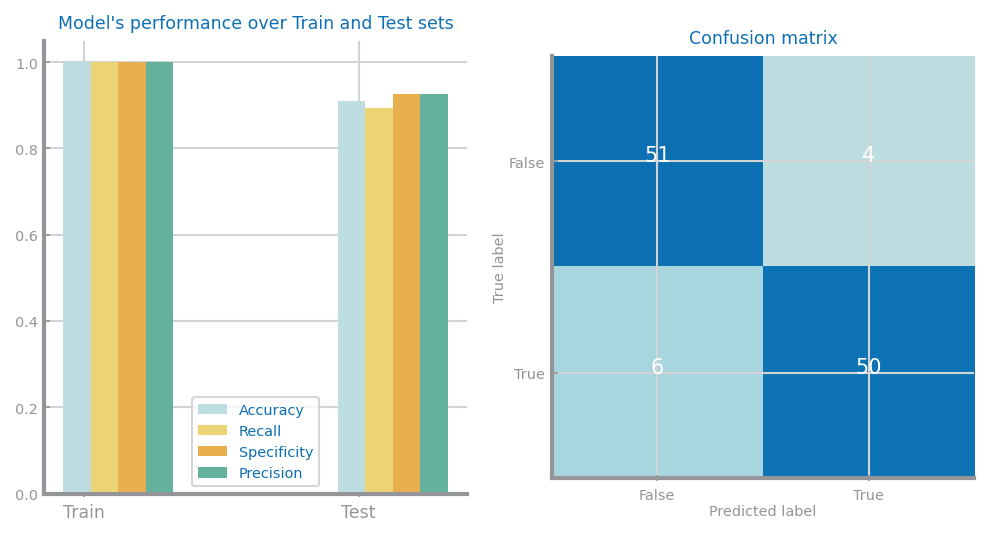

In [17]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

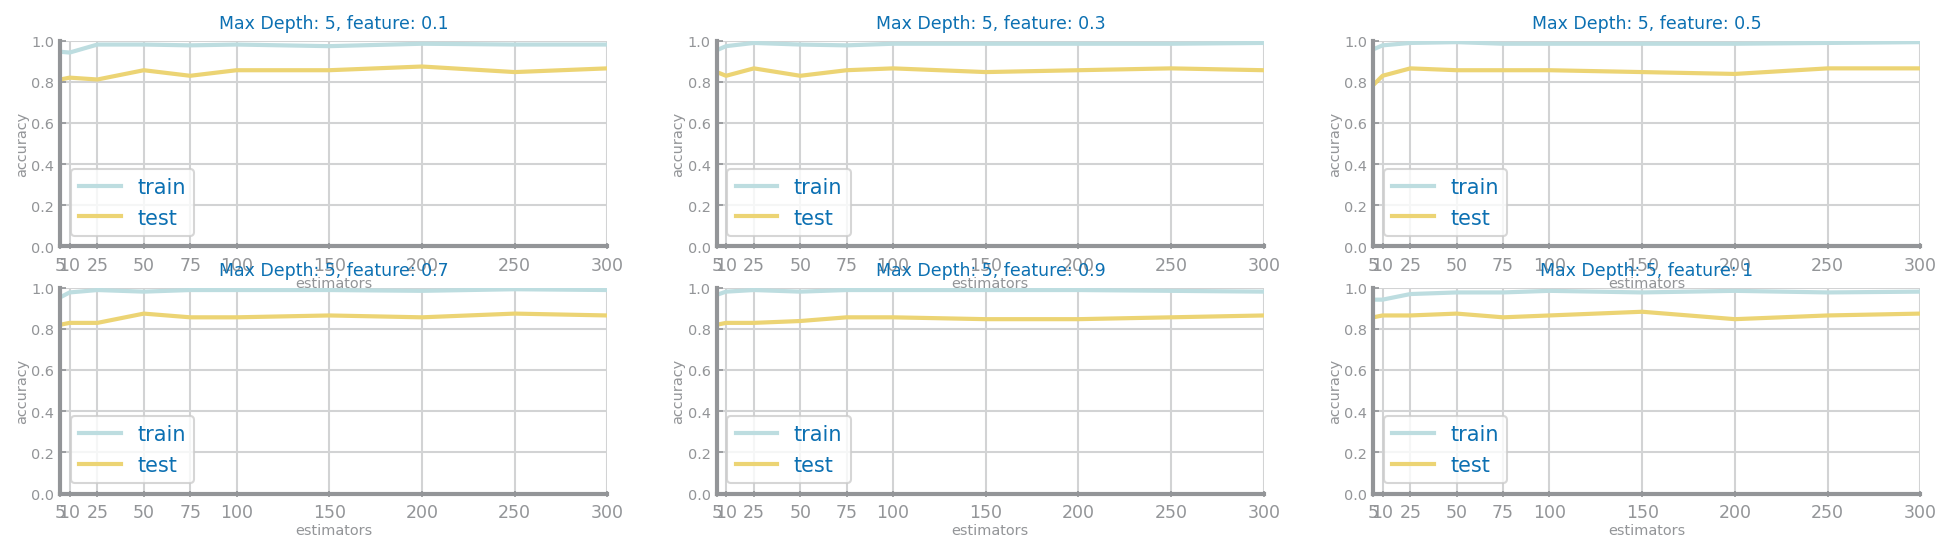

<Figure size 600x450 with 0 Axes>

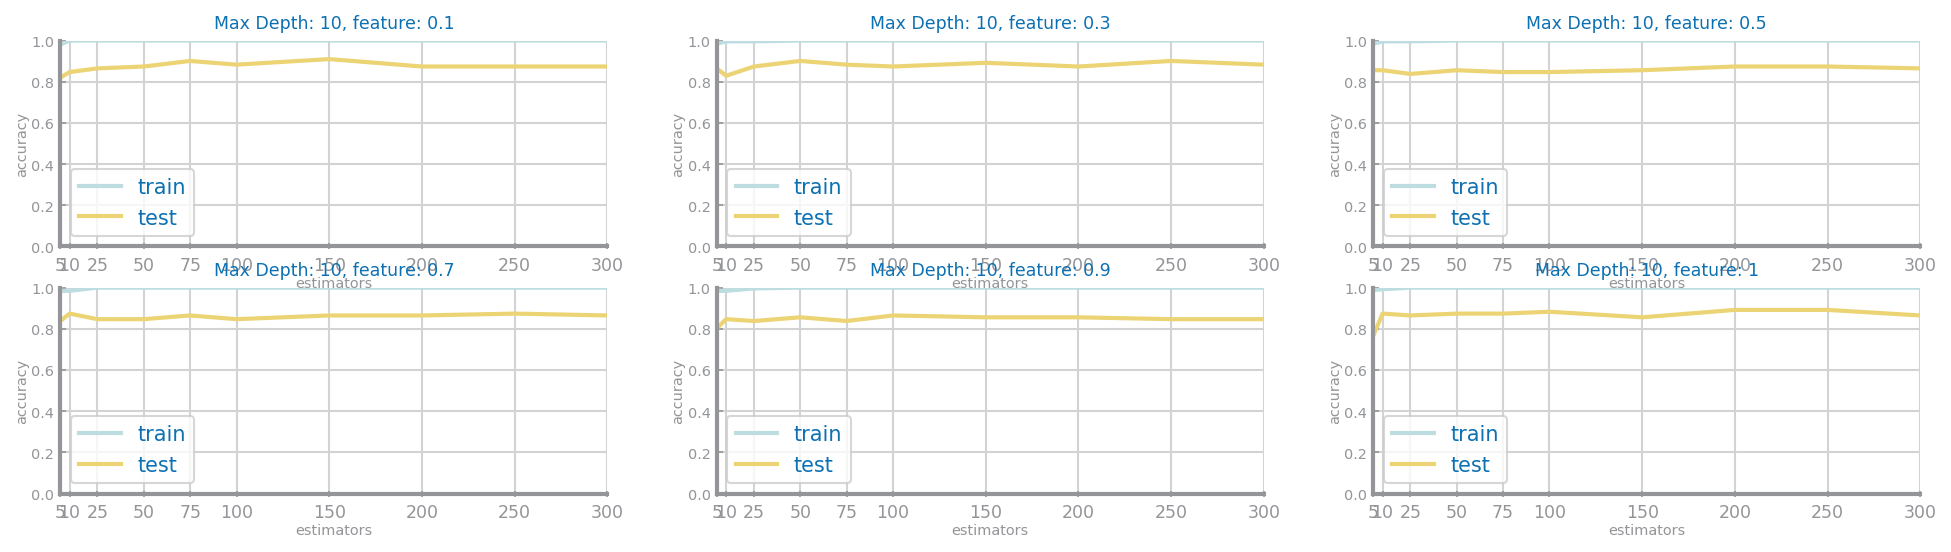

<Figure size 600x450 with 0 Axes>

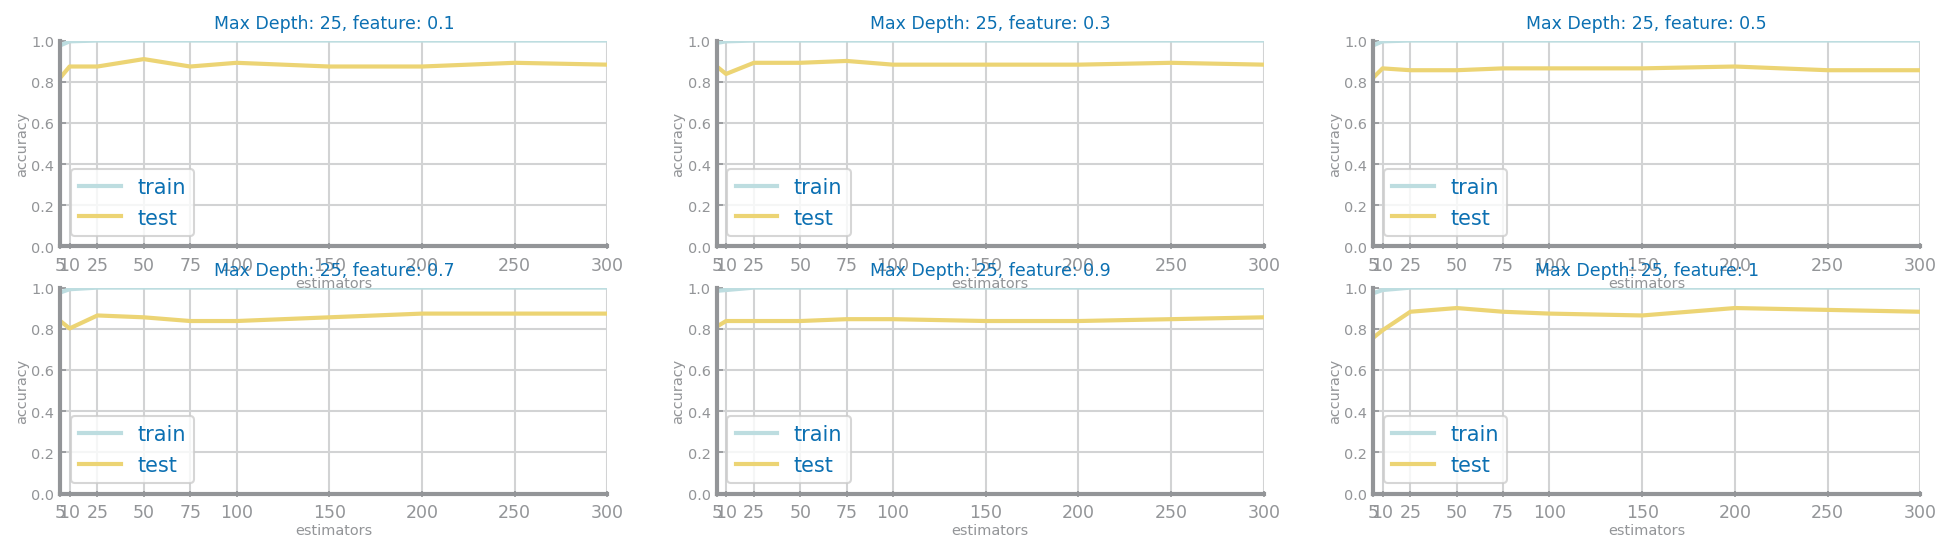

In [18]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_features)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[max_features[i]], 'test': test_values[max_features[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(max_features[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()